## Code Violations Annual Trend Analysis

### The City of Scottsdale publishes a [dataset](http://data.scottsdaleaz.gov/dataset/planning-and-development-code-violations)* that includes closed planning and development cases for one rolling year, updated weekly.  I'm interested in understanding how various *Violation Categories* and more specifically *Violation Codes* are distributed throughout the year.  Am I able to make conclusions about why the distributions take the form that they do?

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pyodbc
import pandas as pd
import seaborn as sns
import datetime
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# SQL query to import all citation data
code_violations_query = ''' select * from [City_of_Scottsdale].[dbo].[np_CodeViolations] '''

code_violations = pd.read_sql(code_violations_query, connection)
connection.close()

# convert date fields from object to datetime format to be able to perform math below
code_violations['_DateComplaintReceived_'] = pd.to_datetime(code_violations['_DateComplaintReceived_'])
code_violations['_DateComplaintClosed_'] = pd.to_datetime(code_violations['_DateComplaintClosed_'])

# find difference between date complaint was received and when it was closed
code_violations['Open_Close_Dif'] = code_violations['_DateComplaintClosed_'] - code_violations['_DateComplaintReceived_']

code_violations['Open_Close_Dif_Days'] = code_violations['Open_Close_Dif']. \
    apply(lambda x: str(x)[-25:-20]) # extract the hour of the day from the datetime column

# convert difference in days to number
code_violations['Open_Close_Dif_Days'] = pd.to_numeric(code_violations['Open_Close_Dif_Days'],errors='coerce')

#create dayofyear dimension for date the case was opened and closed
code_violations['Day_of_Year_Opened'] = code_violations['_DateComplaintReceived_'].dt.dayofyear
code_violations['Day_of_Year_Closed'] = code_violations['_DateComplaintClosed_'].dt.dayofyear

#create month dimension for date the case was opened and closed
code_violations['Month_Opened'] = code_violations['_DateComplaintReceived_'].dt.month
code_violations['Month_Closed'] = code_violations['_DateComplaintClosed_'].dt.month

In [63]:
code_violations.head()

,_ViolationID_,_ComplaintID_,_DateComplaintReceived_,_DateComplaintClosed_,_ComplaintStatus_,_ViolationCategory_,_ViolationCode_,_StreetNumber_,_StreetDirection_,_StreetName_,_StreetType_,_SuiteApt_,_UnitNumber_,_ZipCode_,_ParcelCode_,_Subdivision_,_LotNumber_,_Latitude_,_Longitude_,Open_Close_Dif,Open_Close_Dif_Days,Day_of_Year_Opened,Day_of_Year_Closed,Month_Opened,Month_Closed
0,345175,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Administration and Procedures,1.1101,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704476507594002,-111.875733989498,1640 days 22:41:33.774000,1640.0,21,201,1,7
1,345176,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Article VI SUPPLEMENTARY DISTRICTS: Sec...,6.1060.A.1,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704476507594002,-111.875733989498,1640 days 22:41:33.774000,1640.0,21,201,1,7
2,345177,238737,2014-01-21 09:46:48.483,2018-07-20 08:28:22.257,CLOSED-NOV ISSUED,Zoning-Native Plant Program,7.501.1.b,9514,E,MARIPOSA GRANDE,DR,,,85255,217-05-006B,,,33.704476507594002,-111.875733989498,1640 days 22:41:33.774000,1640.0,21,201,1,7
3,355908,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,3.100,8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464122828002,-111.90472166974,1702 days 05:43:57.657000,1702.0,223,99,8,4
4,356293,247116,2014-08-11 09:54:15.710,2019-04-09 15:38:13.367,CLOSED-NOV ISSUED,Zoning-Uses Permitted Residential,5.012(A)(R1-190),8144,E,VIA DONA,RD,,,85266,216-70-005T,,,33.749464122828002,-111.90472166974,1702 days 05:43:57.657000,1702.0,223,99,8,4


In [31]:
# date range for the data downloaded, one year, rolling based on date complaints are closed
# some of these have been open for a number of years
print(code_violations['_DateComplaintReceived_'].min())
print(code_violations['_DateComplaintReceived_'].max())

print(code_violations['_DateComplaintClosed_'].min())
print(code_violations['_DateComplaintClosed_'].max())

2014-01-21 09:46:48.483000
2019-04-26 15:46:01.450000
2018-04-30 07:03:54.783000
2019-04-27 17:19:42.640000


## What are the most common Violation Categories?

In [6]:
# by a long shot land has the most violations
top_violation_category = code_violations.groupby('_ViolationCategory_')['_ViolationCategory_'].count().sort_values(ascending=False).head(10)

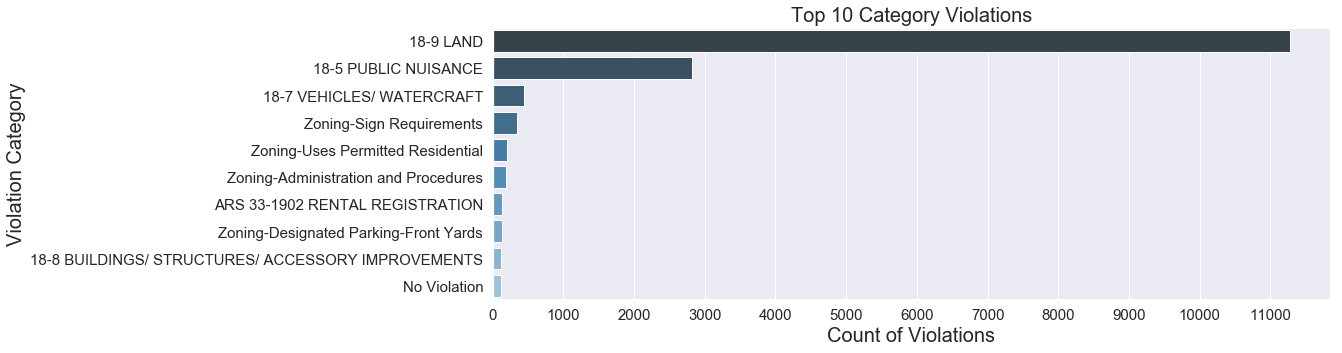

In [34]:
sns.set(rc={'figure.figsize':(15, 5)})

ax = sns.barplot(top_violation_category.values, top_violation_category.index, palette="Blues_d")
plt.title('Top 10 Category Violations',fontsize=20)
plt.ylabel('Violation Category',fontsize=20)
plt.xlabel('Count of Violations',fontsize=20)
plt.tick_params(labelsize=15)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1000))

## How does the volume of violations opened and closed track throughout the year?

In [40]:
opened = code_violations.groupby('Day_of_Year_Opened')['Day_of_Year_Opened'].count().to_frame()
closed = code_violations.groupby('Day_of_Year_Closed')['Day_of_Year_Closed'].count().to_frame()

open_close_day_of_year = opened.merge(closed, left_index=True, right_index=True)
open_close_day_of_year.index.rename('Day_of_Year', inplace=True)
open_close_day_of_year.reset_index(inplace=True)

pd.melt(open_close_day_of_year, id_vars='Day_of_Year').head()

,Day_of_Year,variable,value
0,2,Day_of_Year_Opened,30
1,3,Day_of_Year_Opened,41
2,4,Day_of_Year_Opened,34
3,7,Day_of_Year_Opened,24
4,8,Day_of_Year_Opened,36


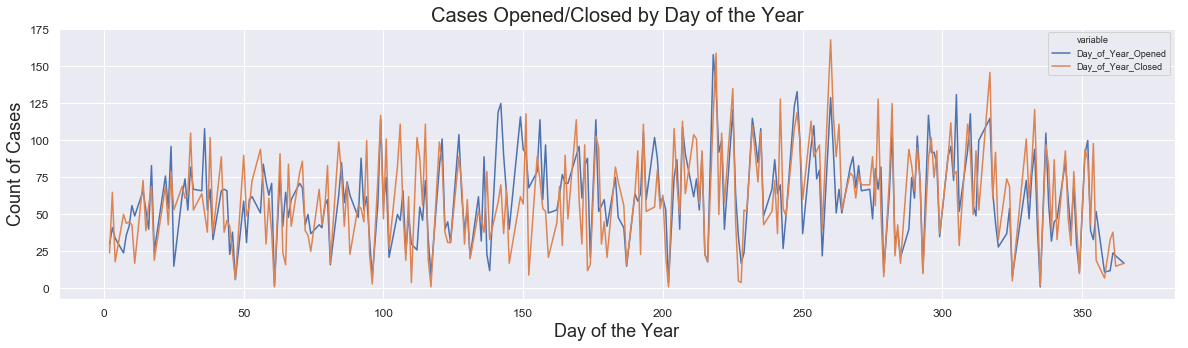

In [59]:
sns.set(rc={'figure.figsize':(20,5)})
sns.lineplot(x=pd.melt(open_close_day_of_year, id_vars='Day_of_Year').iloc[:,0], \
             y=pd.melt(open_close_day_of_year, id_vars='Day_of_Year').iloc[:,2], \
             hue=pd.melt(open_close_day_of_year, id_vars='Day_of_Year').iloc[:,1], \
             data=pd.melt(open_close_day_of_year, id_vars='Day_of_Year'))

plt.title("Cases Opened/Closed by Day of the Year",fontsize=20)
plt.xlabel("Day of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=9)

# ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(25))

### The count of violations on any given day of the year shows a high level of fluctuation, with a slight increase visible in the latter half of the year.  Aggregating by month and graphing by that will be a better guage of an annual trend.

In [42]:
opened_month = code_violations.groupby('Month_Opened')['Month_Opened'].count().to_frame()
closed_month = code_violations.groupby('Month_Closed')['Month_Closed'].count().to_frame()

open_close_month_of_year = opened_month.merge(closed_month, left_index=True, right_index=True)
open_close_month_of_year.index.rename('Month_of_Year', inplace=True)

open_close_month_of_year.reset_index(inplace=True)
open_close_month_of_year.head()

pd.melt(open_close_month_of_year, id_vars='Month_of_Year').head()

,Month_of_Year,variable,value
0,1,Month_Opened,1100
1,2,Month_Opened,1147
2,3,Month_Opened,1205
3,4,Month_Opened,1214
4,5,Month_Opened,1456


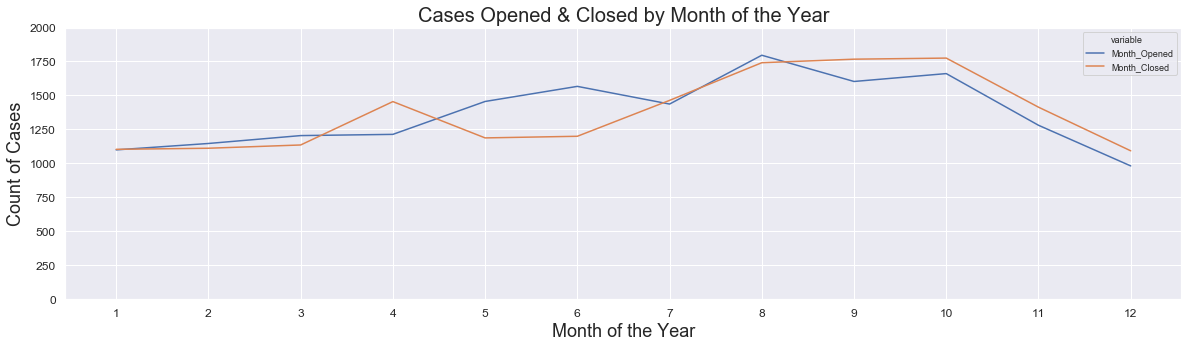

In [70]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.lineplot(x=pd.melt(open_close_month_of_year, id_vars='Month_of_Year').iloc[:,0], \
             y=pd.melt(open_close_month_of_year, id_vars='Month_of_Year').iloc[:,2], \
             hue=pd.melt(open_close_month_of_year, id_vars='Month_of_Year').iloc[:,1], \
             data=pd.melt(open_close_month_of_year, id_vars='Month_of_Year'))

plt.title("Cases Opened & Closed by Month of the Year",fontsize=20)
plt.xlabel("Month of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.ylim(bottom=1, top=2000)
plt.tick_params(labelsize=12)
plt.legend(fontsize=9)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.savefig("visualizations/Cases Opened & Closed by Month of the Year.png")

### Although the volume of violations tracks quite closely, why is there a spike between August and November?  Does any specific violation category contribute most to the spike at this time of year?

In [43]:
# filter only data for the top 5 violations
top_5_violations_data = code_violations[code_violations['_ViolationCategory_'].isin(top_violation_category.head().index)]

In [46]:
# form data into tidy format to be able to graph
top_5_month_opened = pd.melt(top_5_violations_data.groupby(['Month_Opened', '_ViolationCategory_'])['Month_Opened'].count().unstack().reset_index(), id_vars='Month_Opened')
top_5_month_opened.head()

,Month_Opened,_ViolationCategory_,value
0,1,18-5 PUBLIC NUISANCE,177
1,2,18-5 PUBLIC NUISANCE,138
2,3,18-5 PUBLIC NUISANCE,179
3,4,18-5 PUBLIC NUISANCE,213
4,5,18-5 PUBLIC NUISANCE,237


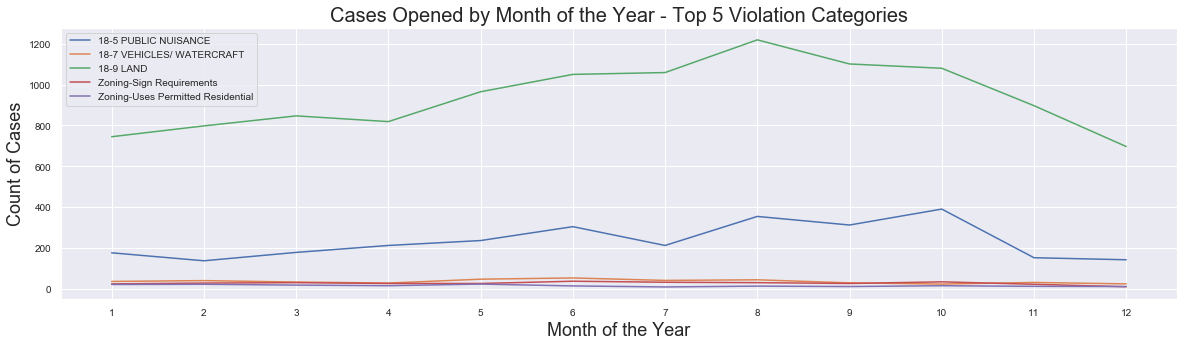

In [71]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.lineplot(x=top_5_month_opened.iloc[:,0], \
             y=top_5_month_opened.iloc[:,2], \
             hue=top_5_month_opened.iloc[:,1], \
             data=top_5_month_opened)

plt.title("Cases Opened by Month of the Year - Top 5 Violation Categories",fontsize=20)
plt.xlabel("Month of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=10)
plt.legend(fontsize=10)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.savefig("visualizations/Cases Opened by Month of the Year - Top 5 Violation Categories.png")

### "18-9 LAND" Violations by far make up the most cases opened throughout the year, with the highest point in August.  But what about the trendline of cases closed throughout the year?

In [20]:
top_5_month_closed = pd.melt(top_5_violations_data.groupby(['Month_Closed', '_ViolationCategory_'])['Month_Closed'].count().unstack().reset_index(), id_vars='Month_Closed')
top_5_month_closed.head()

,Month_Closed,_ViolationCategory_,value
0,1,18-5 PUBLIC NUISANCE,203
1,2,18-5 PUBLIC NUISANCE,138
2,3,18-5 PUBLIC NUISANCE,152
3,4,18-5 PUBLIC NUISANCE,215
4,5,18-5 PUBLIC NUISANCE,231


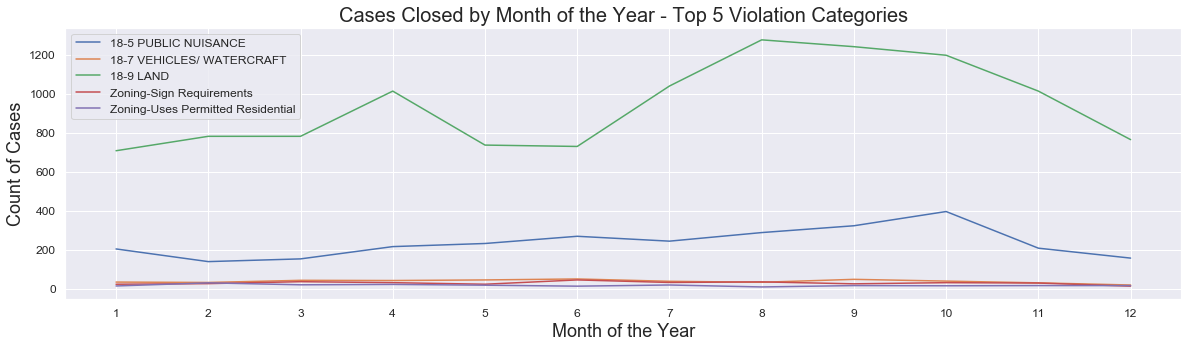

In [65]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.lineplot(x=top_5_month_closed.iloc[:,0], \
             y=top_5_month_closed.iloc[:,2], \
             hue=top_5_month_closed.iloc[:,1], \
             data=top_5_month_closed)

plt.title("Cases Closed by Month of the Year - Top 5 Violation Categories",fontsize=20)
plt.xlabel("Month of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())

### A large number of "18-9 LAND" violations issued April - June are closed August - October.  Taking a closer look at "18-9 LAND" violations, do any specific violation codes feature most prominently at specific times of the year?

In [49]:
# which specific sub-categories within 'Land' have the most code violations?
land_violations = code_violations.groupby(['_ViolationCategory_','_ViolationCode_'])['_ViolationCategory_'] \
    .count() \
    .unstack() \
    .loc['18-9 LAND'] \
    .dropna() \
    .sort_values(ascending=False)

land_violations.head()

_ViolationCode_
18-9(H)                                               3765.0
18-9(A)(4) Uncultivated Growth in Desert Landscape    2793.0
18-9(B)                                               1017.0
18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs)        888.0
18-9(A)(4) Tall Grass/Weeds/Overgrown Vegetation       870.0
Name: 18-9 LAND, dtype: float64

In [51]:
#filter for only the top 5 "18-9 Land" violations
top_5_land_violations = code_violations[code_violations['_ViolationCode_'].isin(land_violations.head().index)]
top_5_land_month_opened = pd.melt(top_5_land_violations.groupby(['Month_Opened', '_ViolationCode_'])['Month_Opened'].count().unstack().reset_index(), id_vars='Month_Opened')
top_5_land_month_opened.head()

,Month_Opened,_ViolationCode_,value
0,1,18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs),22
1,2,18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs),21
2,3,18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs),19
3,4,18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs),23
4,5,18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs),61


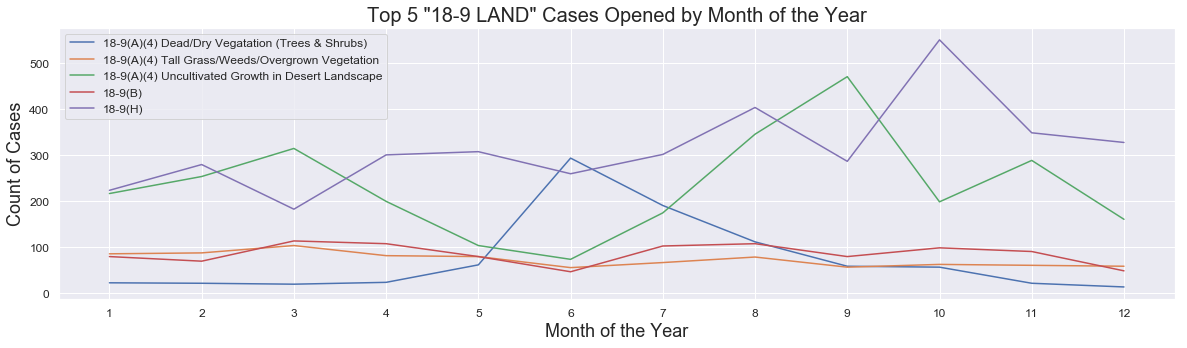

In [74]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.lineplot(x=top_5_land_month_opened.iloc[:,0], \
             y=top_5_land_month_opened.iloc[:,2], \
             hue=top_5_land_month_opened.iloc[:,1], \
             data=top_5_land_month_opened)

plt.title('Top 5 "18-9 LAND" Cases Opened by Month of the Year',fontsize=20)
plt.xlabel("Month of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.savefig('visualizations/Top 5 LAND Cases Opened by Month of the Year.png')

## Analysis on the top 3:  

### Section 18-9(A)(4) Uncultivated Growth in Desert Landscape - My sense is that most of these violoations are related to grass greater than 6 inches high.  These violations spike in March(after spring rains), and September(after summer monsoon rains).

### Section 18-9(A)(4) Dead/Dry Vegatation (Trees & Shrubs) - The inverse of the above violation, the monthly frequency of this violation tracks with dryest time of the year(June) between spring rains and summer monsoons when plants that aren't receiving addequate suplementary watering will die.

### Section 18-9(H) - This violation has a strong spike in October.  Since the data I'm working with includes the later part of 2018, this spike could be in response to the flood of policital posters preceding elections/voting in November.

### See below for full city ordinance, and link to full City of Scottsdale ordinance.

# [Sec. 18-9. - Land.](https://library.municode.com/az/scottsdale/codes/code_of_ordinances?nodeId=REVISED_CODEVO1_CH18PUNUPRMA_ARTIIIPRMA_S18-9LA)

#### (a) The owner and/or occupant of land shall maintain the land free of: (1) Blight, garbage, litter or debris; (2) Noxious exhalations and other airborne irritations, including, but not limited to, smoke, soot, dust, fumes or other gases, offensive odors, or other annoyances; (3) Plant growth, infestation and any other condition that encourages infestation or otherwise adversely affects the aesthetic or general welfare of individuals or the public. __(4) Grass higher than six (6) inches, poison oak, poison ivy, and weeds; or plant growth that is dead, dry, uncultivated or overgrown.__

#### **(b) In addition to the requirements of subsection 18-9(a) above, the owner and/or occupant of land shall also maintain the following areas free of grass higher than six (6) inches, poison oak, poison ivy, weeds, blight, garbage, litter and debris: adjacent rights-of-way from the back of the curb or edge of paving in the street, through the owner's and/or occupant's land, to the centerline of any adjacent alley or right-of-way.** 

(c) In addition to the requirements of subsection 18-9(b) above, the owner and/or occupant of a business shall maintain the parking lot and landscaped areas adjacent to or surrounding the business free of grass higher than six (6) inches, weeds, garbage, litter and debris. 

(d) The owner and/or occupant of land that has been subject to dumping shall take measures to secure the land to prevent future dumping. The measures may include erecting a fence, constructing a ditch and berm, or placing four (4) foot high posts at four (4) foot intervals. Any measures under this subsection shall be taken only in conformance with required permits. 

(e) Except as otherwise permitted by law and by the landowner in writing, no person shall place clean fill or fill dirt on land of another. 

(f) The owner and/or occupant of land where a pool is located shall maintain the pool to avoid health or safety hazards, infestation, pollution, stagnation and blight. 

(g) No person shall attach any sign to any public utility structure, traffic control device, streetlight standard, or similar structure in the street, right-of-way or public place. 

#### **(h) Except as otherwise permitted by law, no person shall place any structure or sign in the street, right-of-way or public place.**

## For the second highest category of violation(18-5 PUBLIC NUISANCE), what are the top 5 violation codes?  How do those track across the year?

In [26]:
# which specific sub-categories within 'Land' have the most violations?
top_5_public_nuisance_violations = code_violations.groupby(['_ViolationCategory_','_ViolationCode_'])['_ViolationCategory_'] \
    .count() \
    .unstack() \
    .loc['18-5 PUBLIC NUISANCE'] \
    .dropna() \
    .sort_values(ascending=False)

top_5_public_nuisance_violations.head()

_ViolationCode_
18-5 (11)    1200.0
18-5 (19)     460.0
18-5 (17)     351.0
18-5 (8)      197.0
18-5 (12)     170.0
Name: 18-5 PUBLIC NUISANCE, dtype: float64

In [56]:
# filter only for data for the top 5 violations within the '18-5 PUBLIC NUISANCE' category
# form into tidy format
top_5_violations_public_nuisance_data = code_violations[code_violations['_ViolationCode_'].isin(top_5_public_nuisance_violations.head().index)]
top_5_violations_public_nuisance_data.groupby(['Month_Opened', '_ViolationCode_'])['Month_Opened'].count().unstack().reset_index()
top_5_public_nuisance_opened = pd.melt(top_5_violations_public_nuisance_data.groupby(['Month_Opened', '_ViolationCode_'])['Month_Opened'].count().unstack().reset_index(), id_vars='Month_Opened')
top_5_public_nuisance_opened.head()

,Month_Opened,_ViolationCode_,value
0,1,18-5 (11),79
1,2,18-5 (11),50
2,3,18-5 (11),53
3,4,18-5 (11),77
4,5,18-5 (11),76


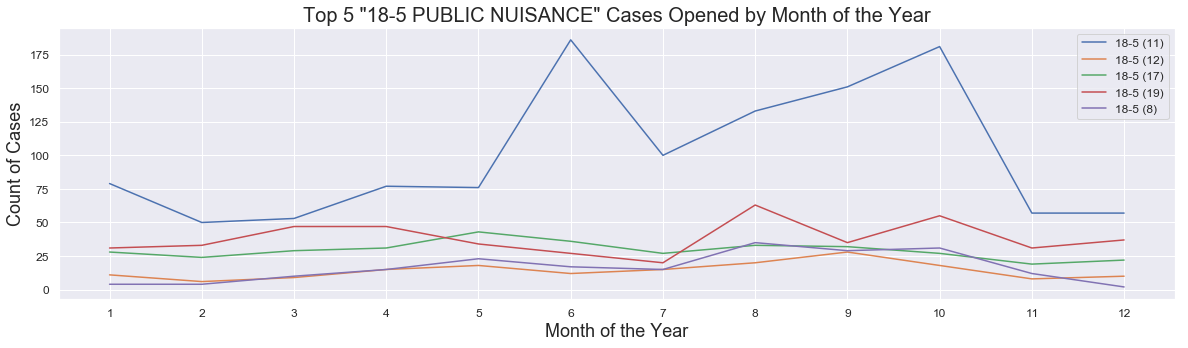

In [75]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.lineplot(x=top_5_public_nuisance_opened.iloc[:,0], \
             y=top_5_public_nuisance_opened.iloc[:,2], \
             hue=top_5_public_nuisance_opened.iloc[:,1], \
             data=top_5_public_nuisance_opened)

plt.title('Top 5 "18-5 PUBLIC NUISANCE" Cases Opened by Month of the Year',fontsize=20)
plt.xlabel("Month of the Year",fontsize=18)
plt.ylabel("Count of Cases",fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.savefig('visualizations/Top 5 PUBLIC NUISANCE Cases Opened by Month of the Year.png')

## Analysis on the top 2:  

### Section 18-5(11) - this code violation has a strong spike in June and October.  It's not clear to me what could be causing these spikes.  Possibly shrubs or other plants near sidewalks, which have received suplemental irrigation from spring rains or summer monsoons are growing more aggressively, thus in the way of someone passing on a sidewalk.

### Section 18-5(19) - the sharpest spike in graffiti violations happens between July and August.  This seems to coincide with when kids go back to school.  Is it possible this has something to do with gang activity and tagging?

### See below for full city ordinance, and link to full City of Scottsdale ordinance.

# [Sec. 18-5. - Public nuisances.](https://library.municode.com/az/scottsdale/codes/code_of_ordinances?nodeId=REVISED_CODEVO1_CH18PUNUPRMA_ARTIIPUNU_S18-5PUNU)

Except as otherwise permitted by law, each of the following conditions is a public nuisance on any land or in any building in the city and is unlawful, when the condition is or may be (i) discomforting or offensive to a reasonable person of normal sensitivity, or (ii) detrimental to the life, health or safety of individuals or the public:

(1) Animal manure that is neither used for fertilizing lawns or gardens nor securely protected from insects and the elements. (2) Putrid, unsound or unwholesome bones, meat, hides, skins, or other animal parts; dead animals, fish or fowl; butcher's trimmings and offal; waste vegetation; liquid waste; animal matter, garbage, human or animal excreta, sewage and other similar offensive substances. (3) A dumping ground or other land or building for depositing litter or debris, or wrecking, disassembling, rebuilding, repair, storage or accumulation of three (3) or more vehicles, or of machinery, or parts of vehicles or machinery. (4) Noxious exhalations and other airborne irritations, including, but not limited to, smoke, soot, dust, fumes or other gases, offensive odors, or other annoyances. (5) Burning litter, debris, sawdust or other material resulting in smoke, gases, ashes, soot, cinders, sawdust or other material being transported to or deposited on land or buildings. (6) Disposing of litter, debris, sawdust or other material in a manner that results in its unauthorized deposit on land or buildings. (7) An unsecured or abandoned excavation, pit, well, other hole or pool. 

### (8) A privy, vault, cesspool, sump, pit, pool, accumulated water or similar condition that is foul, malodorous, or subject to infestation, pollution or stagnation. 

(9) An unsecured building that is vacant, abandoned, dilapidated, structurally unsound, partially destroyed or left partially constructed under a lapsed building permit for more than forty-eight (48) consecutive hours. (10) An abandoned, unattended or discarded icebox, refrigerator or other container that has an attached airtight door or lid, snaplock or other locking device that may not be released from the inside. 

### **(11) Plant growth or any other condition, sign, structure, vehicle or watercraft that obstructs or interferes with or renders dangerous the use or passage of any public place, stream or water course.** 

### (12) Plant growth or any other condition, sign, structure, vehicle or watercraft that obstructs or interferes with sight distance or the visibility of any traffic control device or sign. 

(13) Plant growth or any other condition that constitutes a fire hazard or encourages infestation or noxious pests. (14) Infestation. (15) Slum property. (16) A building or land regularly used in the commission of a crime. 

### (17) Blight. 

(18) Attractive nuisances. 

### (19) Graffiti.